## iteration

### load image

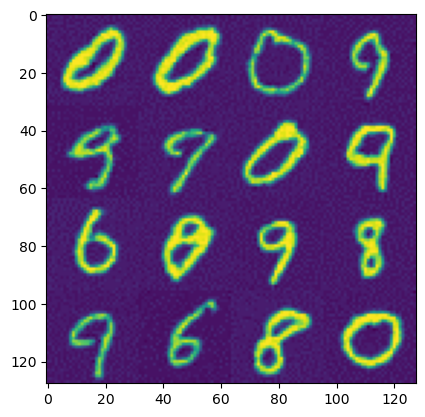

clean: min/max 0.00784313725490196 0.9764705882352941


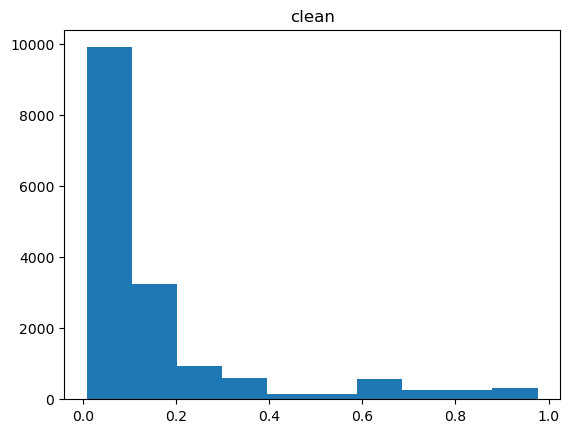

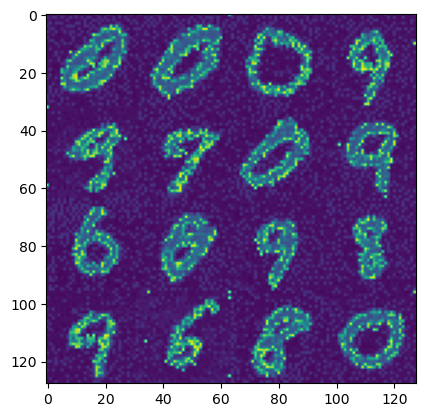

noisy: min/max -0.028053331997446175 1.000906658037007


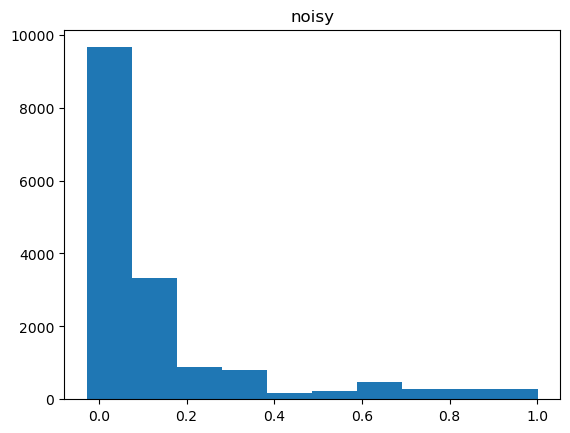

In [9]:
from pathlib import Path

p = Path("/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/Documents/MyReport/DDPM/DDPM-KL-2/images/ddpm-T500-ep78.png")
assert p.exists(),p

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def load(p,show=True):
    img = Image.open(p)
    imga = np.array(img)
    if show:
        plt.imshow(img)
        plt.show()
    return imga

clean = load(p)/255
print("clean: min/max", clean.min(),clean.max())
plt.figure()
plt.title("clean")
plt.hist(clean.flatten())
plt.show()

sigma = 0.01
noisy = clean + np.random.randn(*clean.shape)*sigma
plt.imshow(noisy)
plt.show()
print("noisy: min/max", noisy.min(), noisy.max())
plt.figure()
plt.title("noisy")
plt.hist(noisy.flatten())
plt.show()

In [3]:
import torch
import pytorch_lightning as pl
device = torch.device("cpu")

In [4]:

from dum_tv.apps.model.tv_m import Varia, init_varia


"""kO:int      #     number of kernels; kerK.shape[0]
    kR:int      #     (2*kR+1)  size of kernel
    C:int       #     channel of $f$, the input of DecNet
    kerK:Tensor #     str;  See getKernel_dispatch.
    beta:Tensor #     1,
    rho:Tensor  #     1,"""
varia = Varia(2,1,3,"DxDy",1,1)
init_varia(varia,device)
varia_init = varia._initialized # dict

In [ ]:

from dum_tv.apps.model.tv_m import TVNet

def loop(f,N:int):
    for i in range(N):
        TVNet._step(f,u,p,mu,kerK=kerK,gamma=gamma,rho=rho)